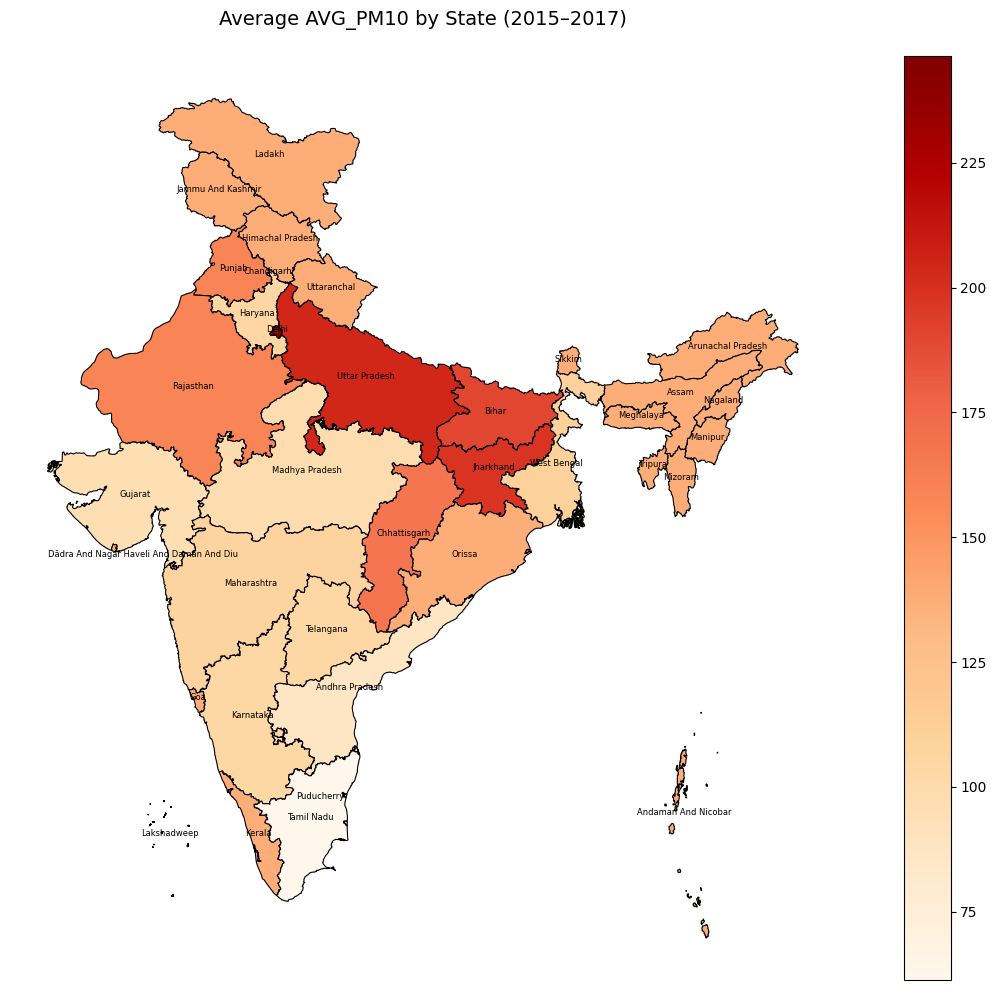

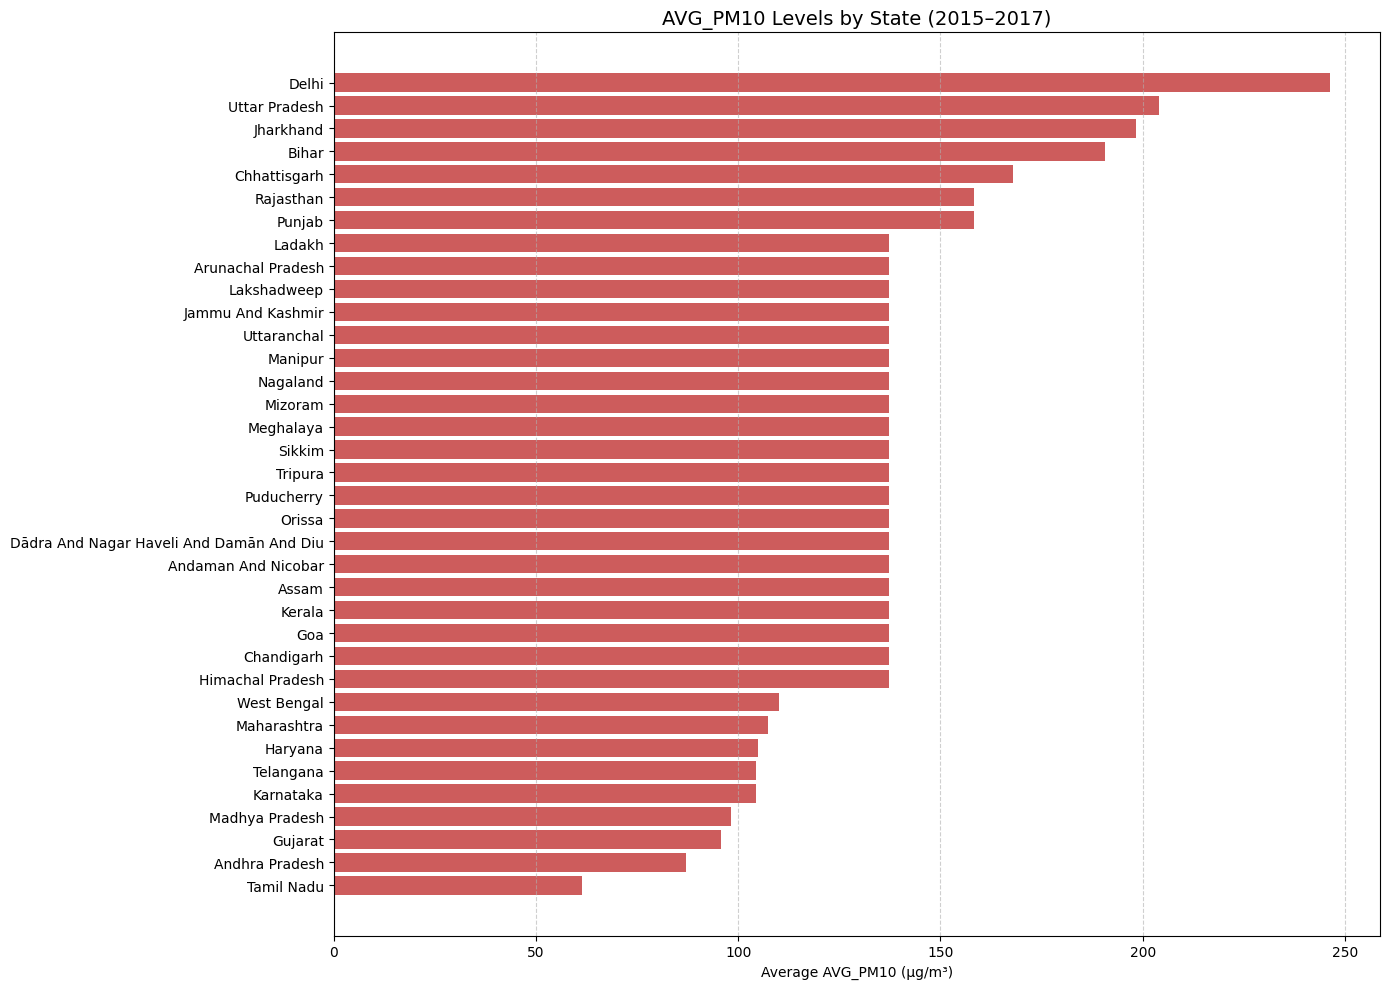

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
 
df = pd.read_csv("RS_Session_246_AU1331.csv")
df.columns = [col.strip().replace(" ", "_").replace("-", "__").lower() for col in df.columns]
 
pollutants = [
    "2015__so2", "2015__no2", "2015__pm10", "2015__pm2.5",
    "2016__so2", "2016__no2", "2016__pm10", "2016__pm2.5",
    "2017__so2", "2017__no2", "2017__pm10", "2017__pm2.5"
]
 
state_avg = df.groupby("state")[pollutants].mean().reset_index()

 
state_avg["avg_pm25"] = state_avg[[c for c in state_avg.columns if "pm2.5" in c]].mean(axis=1)
state_avg["avg_pm10"] = state_avg[[c for c in state_avg.columns if "pm10" in c]].mean(axis=1)
state_avg["avg_no2"] = state_avg[[c for c in state_avg.columns if "no2" in c]].mean(axis=1)

 
state_avg["state"] = state_avg["state"].str.lower().str.strip()
rename_map = {
    "tamilnadu": "tamil nadu",
    "chattisgarh": "chhattisgarh",
    "jammu & kashmir": "jammu and kashmir"
}
state_avg["state"] = state_avg["state"].replace(rename_map)

 
gdf = gpd.read_file("india_states_simple.json")
gdf["state"] = gdf["name"].str.lower().str.strip()

 
pollutant_col = "avg_pm10"   

merged = gdf.merge(state_avg[["state", pollutant_col]], on="state", how="left")
national_avg = state_avg[pollutant_col].mean()
merged[pollutant_col] = merged[pollutant_col].fillna(national_avg) 


fig, ax = plt.subplots(1, 1, figsize=(14, 10))
merged.plot(
    column=pollutant_col,
    cmap="OrRd",
    linewidth=0.8,
    ax=ax,
    edgecolor="black",
    legend=True
)
 
for idx, row in merged.iterrows():
    centroid = row["geometry"].centroid
    ax.annotate(
        text=row["state"].title(),
        xy=(centroid.x, centroid.y),
        ha='center',
        fontsize=6,
        color="black"
    )

ax.set_title(f"Average {pollutant_col.upper()} by State (2015–2017)\n", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

#Bar Graph 
state_bar = merged[["state", pollutant_col]].copy()
state_bar["state"] = state_bar["state"].str.title()
state_bar = state_bar.sort_values(by=pollutant_col, ascending=True)

# Bar chart
plt.figure(figsize=(14, 10))
plt.barh(state_bar["state"], state_bar[pollutant_col], color="indianred")
plt.xlabel(f"Average {pollutant_col.upper()} (µg/m³)")
plt.title(f"{pollutant_col.upper()} Levels by State (2015–2017)", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
